# Image segmentation

Extend your ResNet18 implementation to include a segmentation capabilities. The simplest extension of a backbone network is to simply generate the predictions at the last convolutional feature layer and then upsample them to fit the input image dimensions as described in https://arxiv.org/pdf/1411.4038.pdf (FCN-32s).

For this exercise you will be using the following dataset: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge - You don't have to download it from kaggle as it is already hosted on drive (the script to download it is a few cells down).

For this task, implement the FCN-32s (https://arxiv.org/pdf/1411.4038.pdf), however this is one of the first and simplest fully convolutional segmentation networks and the results will be coarse. You can optionally extend your network with more complex segmentation heads.

A few network architecture that you can optionally implement to improve the results:
- the full FCN network described in https://arxiv.org/pdf/1411.4038.pdf
- PSP-Net https://arxiv.org/pdf/1612.01105.pdf
- DeeplabV3 https://arxiv.org/pdf/1706.05587.pdf


Additionally, implement the U-Net architecture https://arxiv.org/pdf/1505.04597.pdf and use it as a segmentation network. Compare it to your FCN-32s implementation.



## Network implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResNetBlock(nn.Module):
    """
    The ResNet block is a building block for the ResNet18 model. It consists of 2 convolutional layers and a shortcut connection.
    """

    def __init__(self, in_channels, out_channels, stride=1):
        """
        Initializes a ResNet block by defining the 2 convolutional layers and the shortcut connection.

        Args:
            in_channels: The number of input channels.
            out_channels: The number of output channels.
            stride: The stride of the first convolutional layer.
        """
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )


    def forward(self, x):
        """
        Performs a forward pass through the ResNet block.

        Args:
            x: The input tensor.

        Returns:
            The output tensor.
        """
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class ResNet18FCN(nn.Module):

    def __init__(self):
        super(ResNet18FCN, self).__init__()
        # Extend your implementation of ResNet18 and turn it into a segmentation network.
        # Add a segmentation head as described in https://arxiv.org/pdf/1411.4038.pdf
        # The simplest possible extension is to simply generate predictions at the
        # last convolutional feature map and upsample the result.

        # the dataset has 13 possible classes
        num_classes = 13

        self.in_channels = 64
        #self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(ResNetBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResNetBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResNetBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResNetBlock, 512, 2, stride=2)

        # Convolutional layers for segmentation head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        """
        Performs a forward pass through the ResNet18 model.

        Args:
            x: The input tensor.

        Returns:
            The output tensor.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.segmentation_head(out)

        # Upsample to the original input resolution
        #out = F.interpolate(out, scale_factor=8, mode='bilinear', align_corners=False)
        # Upsample to the original input resolution
        out = F.interpolate(out, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)


        return out

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Creates a layer of ResNet blocks.

        Args:
            in_channels: number of input channels
            out_channels: number of output channels
            num_blocks: number of ResNet blocks in the layer
            stride: stride of the first convolutional layer

        Returns:
            a layer of ResNet blocks
        """
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # define the neural network blocks for UNet
        # The implementation details of the network are listed in the paper: https://arxiv.org/pdf/1505.04597.pdf
        num_classes = 13

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down_conv_1 = self._make_double_conv(3, 64)
        self.down_conv_2 = self._make_double_conv(64, 128)
        self.down_conv_3 = self._make_double_conv(128, 256)
        self.down_conv_4 = self._make_double_conv(256, 512)
        self.down_conv_5 = self._make_double_conv(512, 1024)

        # Upsampling layers
        self.up_transpose_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = self._make_double_conv(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = self._make_double_conv(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = self._make_double_conv(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = self._make_double_conv(128, 64)

        # Output layer
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        down_1 = self.down_conv_1(x)
        down_2 = self.max_pool(down_1)
        down_3 = self.down_conv_2(down_2)
        down_4 = self.max_pool(down_3)
        down_5 = self.down_conv_3(down_4)
        down_6 = self.max_pool(down_5)
        down_7 = self.down_conv_4(down_6)
        down_8 = self.max_pool(down_7)
        down_9 = self.down_conv_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        x = self.up_conv_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_conv_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_conv_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_conv_4(torch.cat([down_1, up_4], 1))

        x = self.out(x)
        return x

    def _make_double_conv(self, in_channels, out_channels):
        # Implement the double convolution block
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

##Download the dataset
Download a part of the Lyft self driving dataset split into training and validation sets - https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge


The dataset contains 13 classes:
0 - unlabeled,
1 - building,
2 - fence,
3 - other
4 - pedestrian,
5 - pole
6 - road line
7 - road
8 - sidewalk
9 - vegetation
10 - car
11 - wall
12 - traffic sign






In [ ]:
!pip install --upgrade --no-cache-dir gdown
#!gdown --id 1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM
# if this link does not work try the other link
!gdown --id 1wUFws0e5ArlYUg7NZiAjjrYOmTGCX_Fv
!rm -r data
!mkdir data
!unzip -q seg_data.zip -d ./data/

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wUFws0e5ArlYUg7NZiAjjrYOmTGCX_Fv
From (redirected): https://drive.google.com/uc?id=1wUFws0e5ArlYUg7NZiAjjrYOmTGCX_Fv&confirm=t&uuid=308828e8-4294-4742-a0a3-76074184e419
To: /content/seg_data.zip
100% 2.74G/2.74G [00:14<00:00, 195MB/s]
rm: cannot remove 'data': No such file or directory


## Data loader

In [ ]:
from torch.utils.data import Dataset
import glob
import cv2
import numpy as np

class SegmentationDataset(Dataset):

    def __init__(self, train=True):
        dataset_path = "./data/seg_data/" + ("train" if train else "test")
        self.images = sorted(glob.glob(dataset_path+"/*/*/CameraRGB/*.png"))
        self.masks = sorted(glob.glob(dataset_path+"/*/*/CameraSeg/*.png"))
        self.resize_shape = (320, 416)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path, mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,2]

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        mask = cv2.resize(mask, dsize=(self.resize_shape[1], self.resize_shape[0]))
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        mask = np.array(mask).reshape((image.shape[0], image.shape[1], 1))

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        return image, mask

    def __getitem__(self, idx):
        image, mask = self.transform_image(self.images[idx], self.masks[idx])
        sample = {'image': image, "mask": mask, 'idx': idx}

        return sample

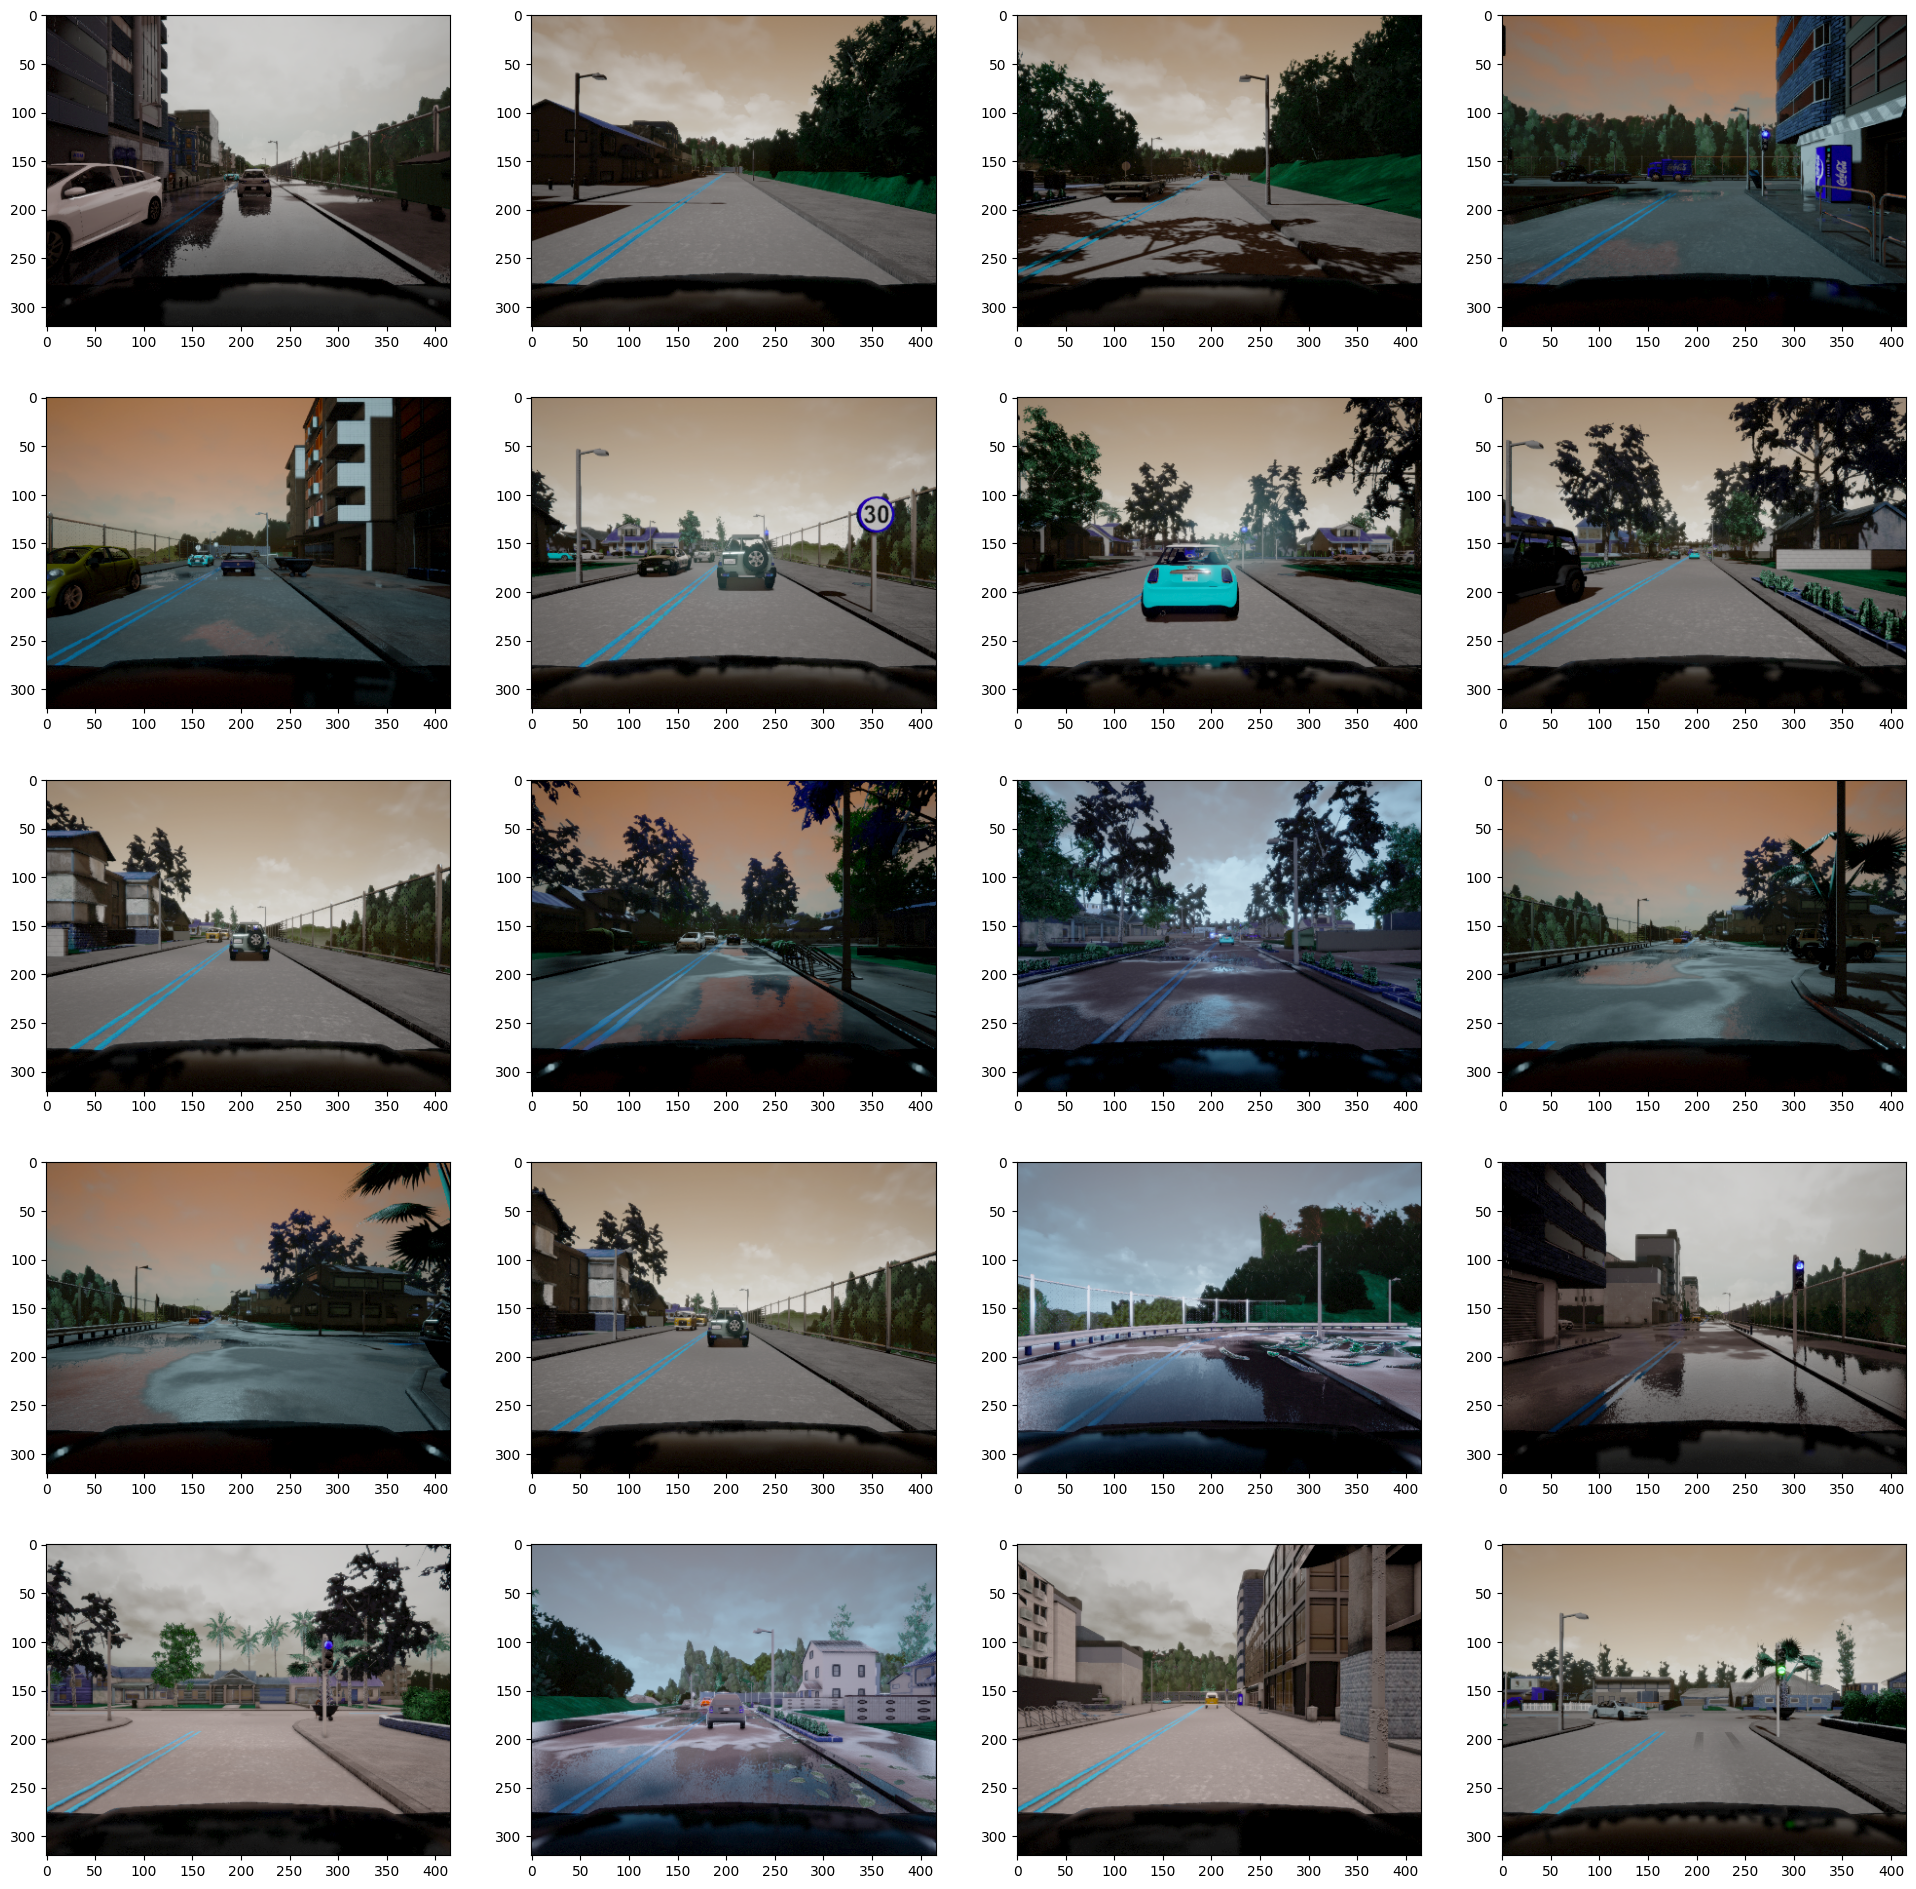

In [ ]:
import torch
from tqdm.notebook import tqdm

trainset = SegmentationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = SegmentationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5
for i in range(rows*columns):
  data = trainset[np.random.randint(len(trainset))]
  input = data["image"]
  label = data["mask"]
  img = input.transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
plt.show()



In [ ]:


import torch.optim as optim

net = UNet()
#net = ResNet18FCN()
net.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)
# epochs=2
epochs = 10
for epoch in range(epochs):  # loop over the dataset multiple times
    with tqdm(total=len(trainset), desc =str(epoch)+"/"+str(epochs), miniters=int(50),unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs = data["image"]
          labels = data["mask"]
          inputs = inputs.cuda()
          labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels[:,0,:,:].long())
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': np.round(loss.data.cpu().detach().numpy(),5)})
          prog_bar.update(4)

0/10:   0%|          | 0/4000 [00:00<?, ?img/s]

1/10:   0%|          | 0/4000 [00:00<?, ?img/s]

2/10:   0%|          | 0/4000 [00:00<?, ?img/s]

3/10:   0%|          | 0/4000 [00:00<?, ?img/s]

4/10:   0%|          | 0/4000 [00:00<?, ?img/s]

5/10:   0%|          | 0/4000 [00:00<?, ?img/s]

6/10:   0%|          | 0/4000 [00:00<?, ?img/s]

7/10:   0%|          | 0/4000 [00:00<?, ?img/s]

8/10:   0%|          | 0/4000 [00:00<?, ?img/s]

9/10:   0%|          | 0/4000 [00:00<?, ?img/s]

## Evaluate on the test set:

Implement the evaluation on the test set. Use the mean IOU metric to evaluate the result. - https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation



In [ ]:
def calculate_metrics(pred, target, num_classes):
    class_TP = []
    class_FP = []
    class_FN = []
    for i in range(num_classes):
        pred_i = pred == i
        target_i = target == i
        TP = (pred_i & target_i).sum()
        FP = (pred_i & ~target_i).sum()
        FN = (~pred_i & target_i).sum()
        class_TP.append(TP.item())
        class_FP.append(FP.item())
        class_FN.append(FN.item())
    return class_TP, class_FP, class_FN

# Use the model to get the predictions
net.eval()
with torch.no_grad():
    total_TP = [0]*13
    total_FP = [0]*13
    total_FN = [0]*13
    for batch in testloader:
        image = batch['image'].cuda()
        mask = batch['mask'].cuda()
        pred = net(image)
        pred = pred.argmax(dim=1)  # get the class with the highest probability
        TP, FP, FN = calculate_metrics(pred, mask, 13)
        for i in range(13):
            total_TP[i] += TP[i]
            total_FP[i] += FP[i]
            total_FN[i] += FN[i]

# Compute the mean IoU for each class and then average them
mean_ious = [TP / (TP + FP + FN) for TP, FP, FN in zip(total_TP, total_FP, total_FN)]
mean_iou = sum(mean_ious) / len(mean_ious)
print(f'Mean IoU score on test set: {mean_iou}')

Mean IoU score on test set: 0.4779782851438704


## Visualize the results

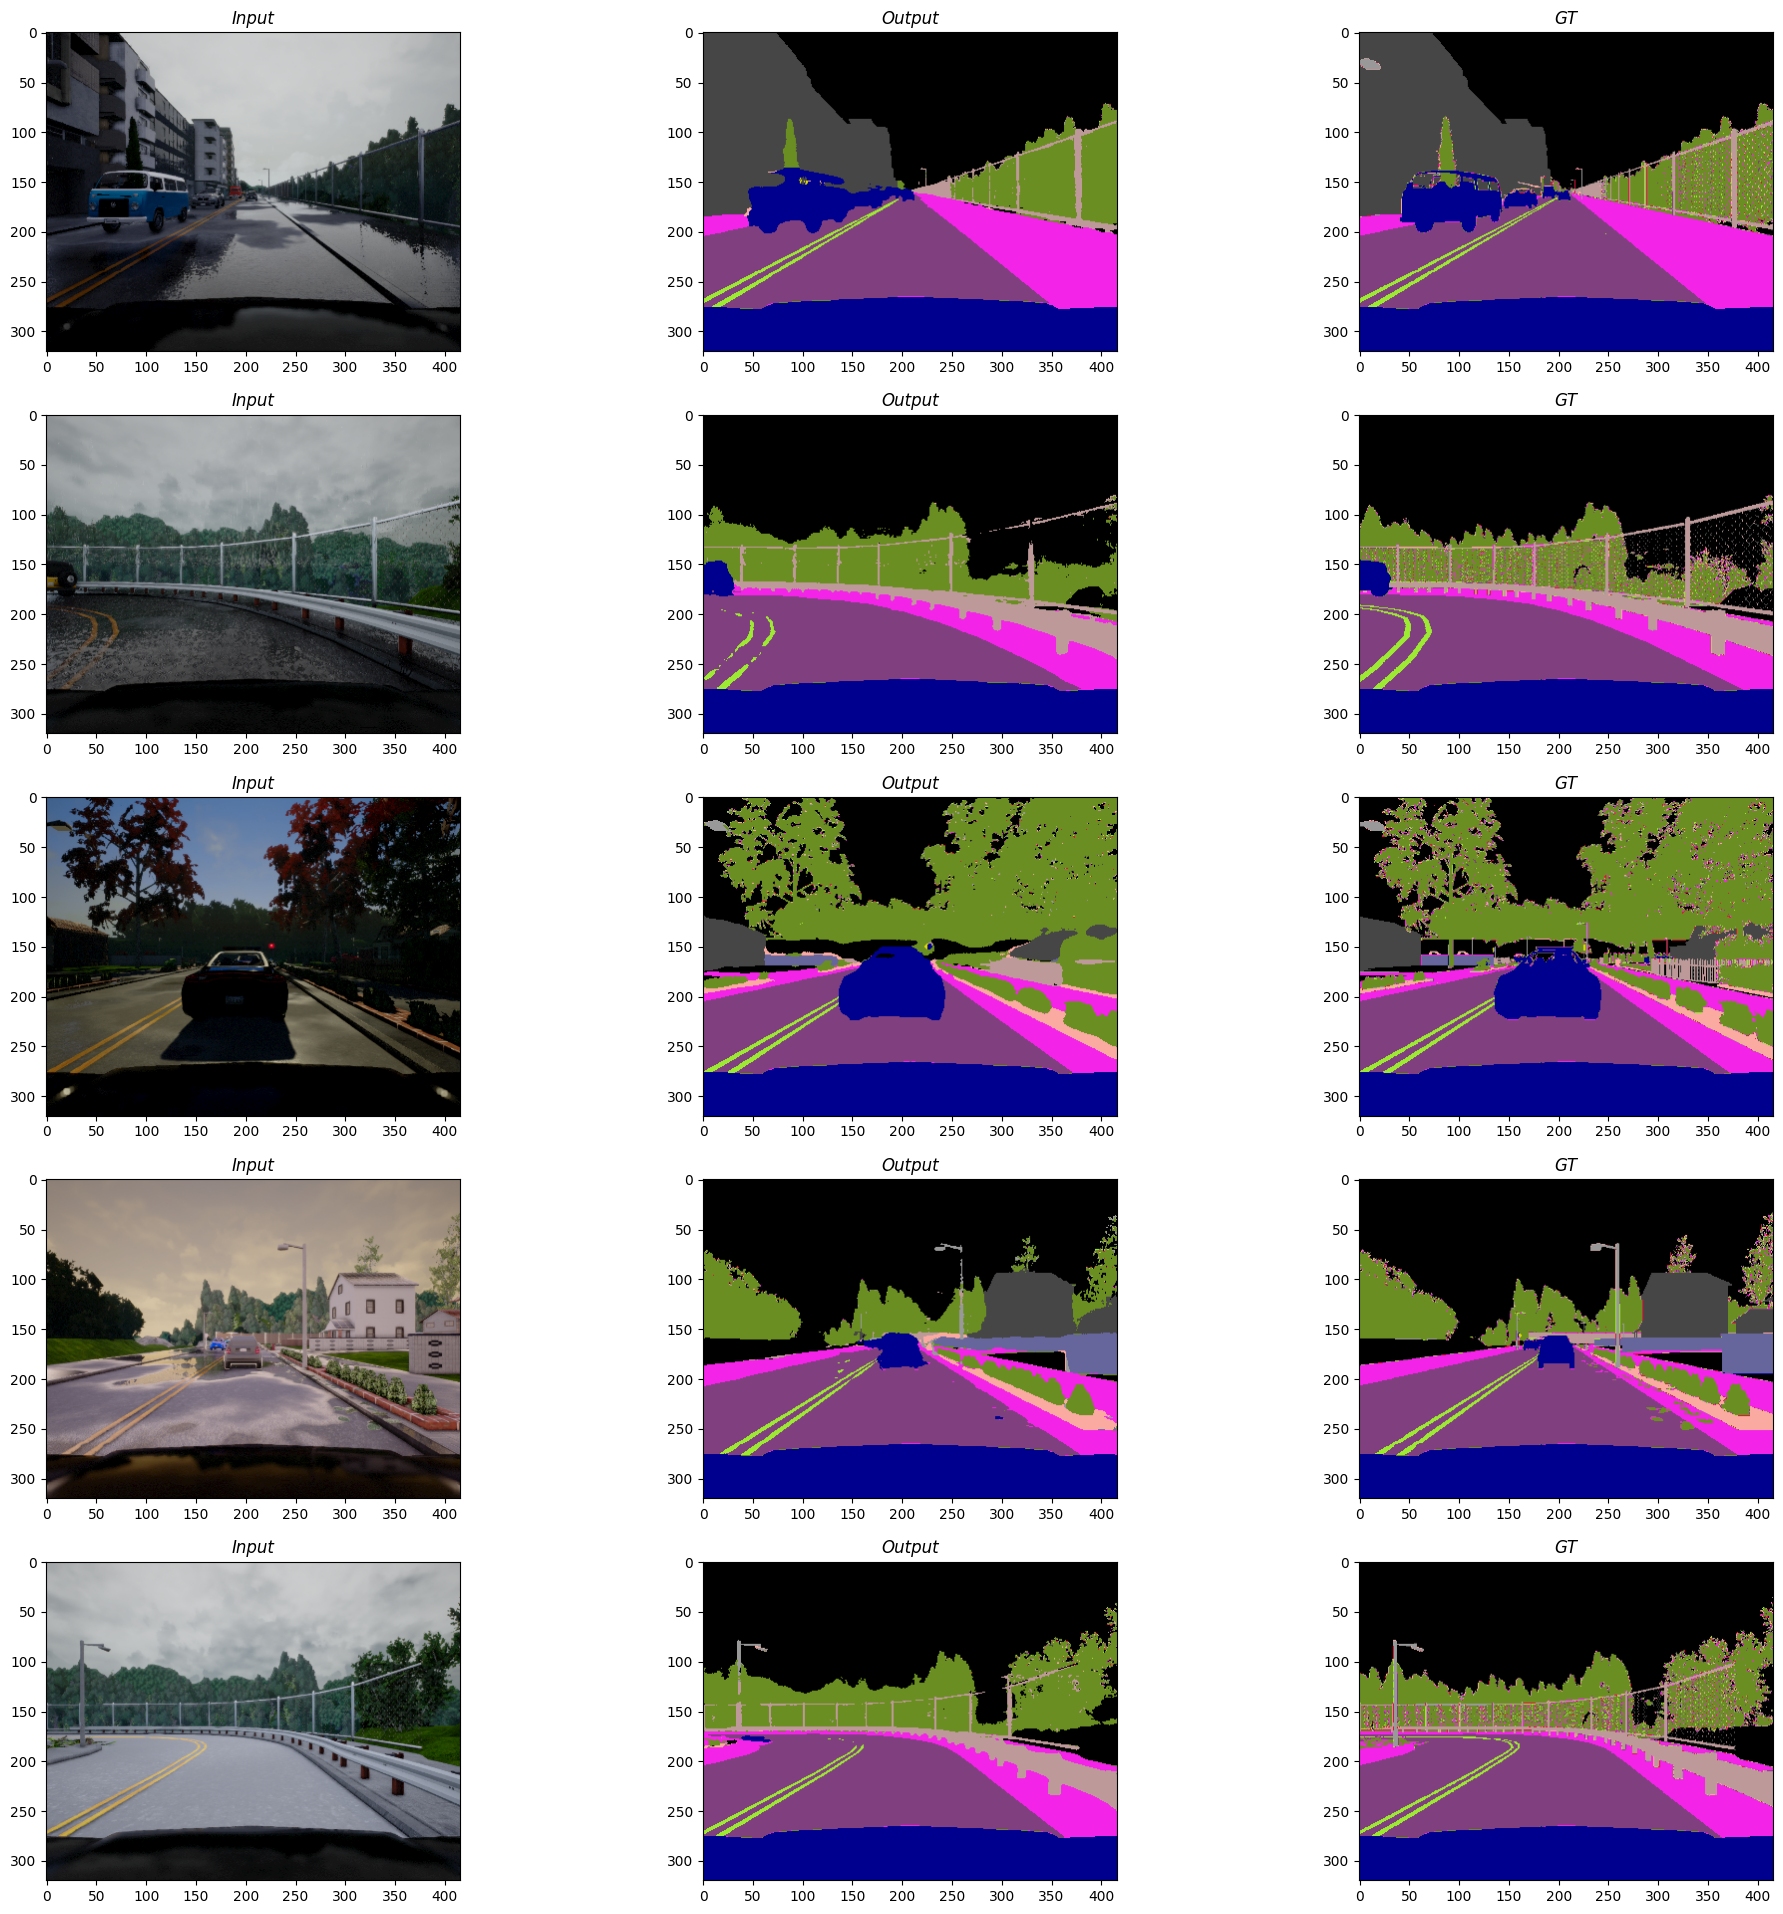

In [ ]:
import matplotlib.pyplot as plt

label_colors = np.array([
[0,0,0], # unlabeled
[70,70,70], # building
[190,153,153], # fence
[250,170,160], # other
[220,20,60], # pedestrian
[153,153,153], # pole
[157,234,50], # road line
[128,64,128], # road
[244,35,232], # sidewalk
[107,142,35], # vegetation
[0,0,142], # car
[102,102,156], # wall
[220,220,0], # traffic sign
])


net.eval()


fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[np.random.randint(len(testset))]
  img = batch['image']
  labels = batch['mask']
  img_tensor = torch.from_numpy(img).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy()
  seg_mask = np.argmax(out_image,axis=0)
  seg_mask_color = label_colors[seg_mask]
  gt_mask_color = label_colors[labels[0,:,:]]

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  labels = labels[0,:,:]
  ax = fig.add_subplot(rows, columns, i*columns+1)
  ax.set_title("Input", fontstyle='italic')
  plt.imshow(img)
  ax = fig.add_subplot(rows, columns, i*columns+2)
  ax.set_title("Output", fontstyle='italic')
  plt.imshow(seg_mask_color)
  ax = fig.add_subplot(rows, columns, i*columns+3)
  ax.set_title("GT", fontstyle='italic')
  plt.imshow(gt_mask_color)


plt.show()